In [1]:
from fitter import Fitter, get_common_distributions, get_distributions
import os
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor
import statsmodels
import statsmodels.api as sm
import seaborn as sns

In [2]:
def append_percentage(x, pos):
    del pos
    return str(int(x))+str('%')

def formatter(x, pos):
    del pos
    return str(int(x*100))+str('%')

In [3]:
# sns.set(
#     context="paper",
#     style="darkgrid",
#     palette="pastel",
#     rc={"figure.dpi": 150}
# )
sns.set_context("paper", font_scale=1.5)

## Load MTTU

In [4]:
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "data"), "mttu"), "mttu.csv")
print (data_file)
df_mttu = pd.read_csv(data_file,
                header=0,
                sep=',',
                on_bad_lines='skip',
                usecols=['system_name', 'from_package_name', 'total_duration', 'out_of_date_duration', 'ratio', 'avg_total_duration', 'avg_out_of_date_duration', 'avg_ratio'],
                )
# df.columns = ['system_name', 'package_name', 'total_requirement_duration', 'out_of_date_duration', 'ratio', 'dependents_approx']
rows = df_mttu.shape[0]
print (df_mttu.shape)
display(df_mttu.head())

/home/imranur/security-metrics/code/visualize-data/../../data/mttu/mttu.csv
(163207, 8)


,system_name,from_package_name,total_duration,out_of_date_duration,ratio,avg_total_duration,avg_out_of_date_duration,avg_ratio
0,CARGO,a10,397,0,0.000000,397.0,0.0,0.000000
1,CARGO,aarch64,481,325,0.675676,481.0,325.0,0.675676
2,CARGO,aardvark-dns,618,0,0.000000,618.0,0.0,0.000000
3,CARGO,ab-av1,582,100,0.171821,582.0,100.0,0.171821
4,CARGO,ab_glyph,3084,78,0.025292,1542.0,39.0,0.025292


In [5]:
df_mttu = df_mttu.dropna()

In [6]:
display(df_mttu[['system_name', 'avg_out_of_date_duration', 'avg_ratio']].groupby(by=['system_name']).describe())

avg_out_of_date_duration                                           \
                               count        mean         std  min  25%    50%   
system_name                                                                     
CARGO                         3301.0  130.537013  265.329598  0.0  0.0   12.5   
NPM                         117129.0  344.657634  449.780841  0.0  0.5  174.0   
PYPI                         42777.0  147.425425  313.079576  0.0  0.0    0.0   

                                avg_ratio                                     \
                    75%     max     count      mean       std  min       25%   
system_name                                                                    
CARGO        129.000000  2596.0    3301.0  0.167245  0.248355  0.0  0.000000   
NPM          517.823529  4296.0  117129.0  0.284610  0.290818  0.0  0.000471   
PYPI         133.545455  3239.0   42777.0  0.136197  0.243295  0.0  0.000000   

                                      
                  50%       75%  max  
system_name                           
CARGO        0.021277  0.304218  1.0  
NPM          0.207750  0.485008  1.0  
PYPI         0.000000  0.162231  1.0

## Load MTTR

In [7]:
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "data"), "mttr"), "mttr.csv")
print (data_file)
df_mttr = pd.read_csv(data_file,
                header=0,
                sep=',',
                on_bad_lines='skip',
                usecols=['system_name', 'from_package_name', 'total_duration', 'total_post_fix_exposure_time', 'ratio', 'avg_total_duration', 'avg_post_fix_exposure_time', 'avg_ratio'],
                )
# df.columns = ['system_name', 'package_name', 'total_requirement_duration', 'post_fix_exposure_time', 'ratio', 'dependents_approx']
rows = df_mttr.shape[0]
print (df_mttr.shape)
display(df_mttr.head())

/home/imranur/security-metrics/code/visualize-data/../../data/mttr/mttr.csv
(22513, 8)


,system_name,from_package_name,total_duration,total_post_fix_exposure_time,ratio,avg_total_duration,avg_post_fix_exposure_time,avg_ratio
0,CARGO,ahrs,826,247,0.299031,826.0,247.0,0.299031
1,CARGO,alloc_geiger,1534,1516,0.988266,1534.0,1516.0,0.988266
2,CARGO,almel,1682,9,0.005351,1682.0,9.0,0.005351
3,CARGO,amp,1637,375,0.229078,1637.0,375.0,0.229078
4,CARGO,broot,1571,563,0.358370,1571.0,563.0,0.358370


In [8]:
df_mttr = df_mttr.dropna()

In [9]:
display(df_mttr[['system_name', 'avg_post_fix_exposure_time', 'avg_ratio']].groupby(by=['system_name']).describe())

avg_post_fix_exposure_time                                       \
                                 count        mean         std  min     25%   
system_name                                                                   
CARGO                             92.0  219.228261  305.965455  1.0   29.75   
NPM                            17263.0  415.817283  423.272107  1.0  111.00   
PYPI                            5158.0  281.235350  277.199696  1.0   82.00   

                                          avg_ratio                      \
                    50%       75%     max     count      mean       std   
system_name                                                               
CARGO         94.000000  313.7500  1516.0      92.0  0.211446  0.255399   
NPM          252.285714  614.0000  3395.0   17263.0  0.316707  0.284607   
PYPI         198.000000  397.1875  2733.0    5158.0  0.313956  0.278196   

                                                          
                  min       25%       50%       75%  max  
system_name                                               
CARGO        0.000826  0.030321  0.091390  0.285675  1.0  
NPM          0.000242  0.093107  0.217178  0.488505  1.0  
PYPI         0.000510  0.094787  0.227258  0.460691  1.0

## Load Dep Specifying Strategy Data

In [10]:
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "data"), "dep_status"), "dep_status.csv")
print (data_file)
df_dep_strategy = pd.read_csv(data_file,
                header=0,
                sep=',',
                on_bad_lines='skip',
                usecols=['system_name', 'from_package_name', 'dependency_status', 'total_rows_with_dependencies', 'floating_count', 'pinned_count'],
                )
rows = df_dep_strategy.shape[0]
print (df_dep_strategy.shape)
display(df_dep_strategy.head())

/home/imranur/security-metrics/code/visualize-data/../../data/dep_status/dep_status.csv
(169670, 6)


,system_name,from_package_name,dependency_status,total_rows_with_dependencies,floating_count,pinned_count
0,CARGO,Boa,mixed,609,608,1
1,CARGO,CreateProcessW,all_floating,70,70,0
2,CARGO,GSL,all_floating,149,149,0
3,CARGO,Lattice,all_floating,490,490,0
4,CARGO,Nuclide,all_floating,11,11,0


## Join to combine dfs

In [11]:
df_mttu_strategy = pd.merge(df_mttu, df_dep_strategy, on=['system_name', 'from_package_name'], how='inner')
df_mttr_strategy = pd.merge(df_mttr, df_dep_strategy, on=['system_name', 'from_package_name'], how='inner')

display(df_mttu_strategy.head())
display(df_mttr_strategy.head())

,system_name,from_package_name,total_duration,out_of_date_duration,ratio,avg_total_duration,avg_out_of_date_duration,avg_ratio,dependency_status,total_rows_with_dependencies,floating_count,pinned_count
0,CARGO,a10,397,0,0.000000,397.0,0.0,0.000000,all_floating,54,54,0
1,CARGO,aarch64,481,325,0.675676,481.0,325.0,0.675676,mixed,33,30,3
2,CARGO,aardvark-dns,618,0,0.000000,618.0,0.0,0.000000,all_floating,445,445,0
3,CARGO,ab-av1,582,100,0.171821,582.0,100.0,0.171821,mixed,1024,1016,8
4,CARGO,ab_glyph,3084,78,0.025292,1542.0,39.0,0.025292,all_floating,129,129,0


,system_name,from_package_name,total_duration,total_post_fix_exposure_time,ratio,avg_total_duration,avg_post_fix_exposure_time,avg_ratio,dependency_status,total_rows_with_dependencies,floating_count,pinned_count
0,CARGO,ahrs,826,247,0.299031,826.0,247.0,0.299031,mixed,171,161,10
1,CARGO,alloc_geiger,1534,1516,0.988266,1534.0,1516.0,0.988266,all_floating,43,43,0
2,CARGO,almel,1682,9,0.005351,1682.0,9.0,0.005351,all_floating,422,422,0
3,CARGO,amp,1637,375,0.229078,1637.0,375.0,0.229078,all_floating,573,573,0
4,CARGO,broot,1571,563,0.358370,1571.0,563.0,0.358370,mixed,6290,6210,80


## Visualization

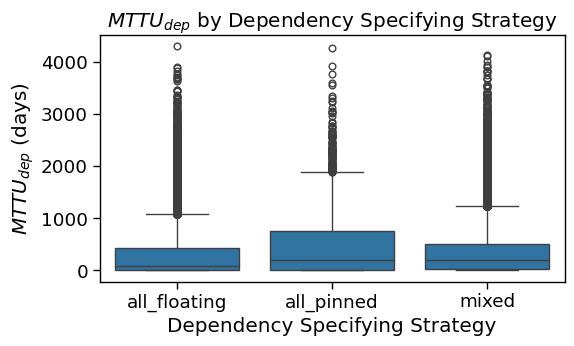

In [31]:
# Visualization for df_mttu_strategy
plt.figure(figsize=(6, 3.2))
sns.boxplot(x='dependency_status', y='avg_out_of_date_duration', data=df_mttu_strategy, order=['all_floating', 'all_pinned', 'mixed'])
plt.title('$MTTU_{dep}$ by Dependency Specifying Strategy')
plt.xlabel('Dependency Specifying Strategy')
plt.ylabel('$MTTU_{dep}$ (days)')
# plt.xticks(rotation=45)
plt.savefig('../../results/dep_strategy/mttu_dep_strategy.pdf', bbox_inches='tight')
plt.show()

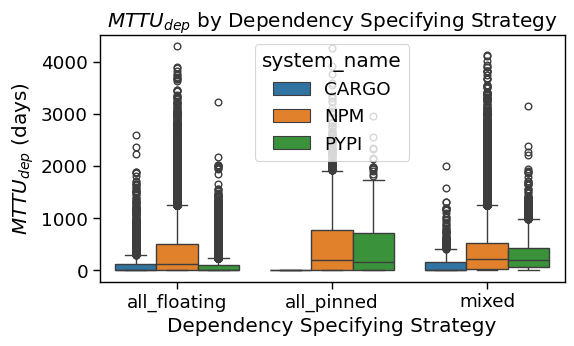

In [32]:
# Visualization for df_mttu_strategy for each ecosystem
plt.figure(figsize=(6, 3.2))
sns.boxplot(x='dependency_status', y='avg_out_of_date_duration', hue='system_name', data=df_mttu_strategy, order=['all_floating', 'all_pinned', 'mixed'])
plt.title('$MTTU_{dep}$ by Dependency Specifying Strategy')
plt.xlabel('Dependency Specifying Strategy')
plt.ylabel('$MTTU_{dep}$ (days)')
# plt.xticks(rotation=45)
plt.savefig('../../results/dep_strategy/mttu_dep_strategy_ecosystem.pdf', bbox_inches='tight')
plt.show()

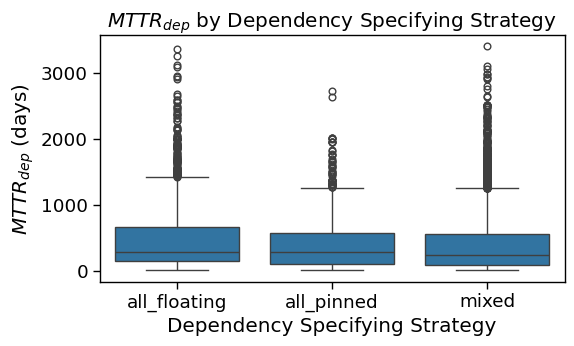

In [35]:
# Visualization for df_mttr_strategy
plt.figure(figsize=(6, 3.2))
sns.boxplot(x='dependency_status', y='avg_post_fix_exposure_time', data=df_mttr_strategy, order=['all_floating', 'all_pinned', 'mixed'])
plt.title('$MTTR_{dep}$ by Dependency Specifying Strategy')
plt.xlabel('Dependency Specifying Strategy')
plt.ylabel('$MTTR_{dep}$ (days)')
# plt.xticks(rotation=45)
plt.savefig('../../results/dep_strategy/mttr_dep_strategy.pdf', bbox_inches='tight')
plt.show()

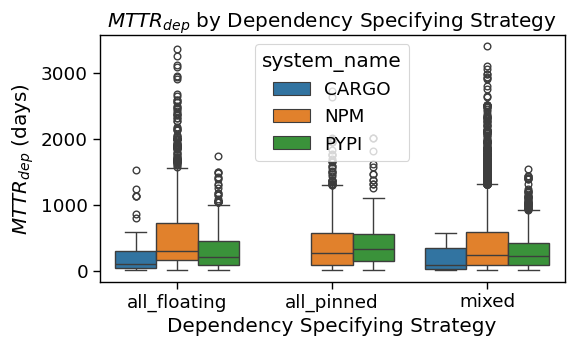

In [34]:
# Visualization for df_mttr_strategy
plt.figure(figsize=(6, 3.2))
sns.boxplot(x='dependency_status', y='avg_post_fix_exposure_time', hue='system_name', data=df_mttr_strategy, order=['all_floating', 'all_pinned', 'mixed'])
plt.title('$MTTR_{dep}$ by Dependency Specifying Strategy')
plt.xlabel('Dependency Specifying Strategy')
plt.ylabel('$MTTR_{dep}$ (days)')
# plt.xticks(rotation=45)
plt.savefig('../../results/dep_strategy/mttr_dep_strategy_ecosystem.png', bbox_inches='tight')
plt.show()

## Number of times a package updates its pinned dependencies

In [2]:
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "data"), "dep_status"), "pinned_dependency_updates.csv")
print(data_file)
df_pinned_updates = pd.read_csv(data_file,
                header=0,
                sep=',',
                on_bad_lines='skip')
rows = df_pinned_updates.shape[0]
print(df_pinned_updates.shape)
display(df_pinned_updates.head(10))

/home/imranur/security-metrics/code/visualize-data/../../data/dep_status/pinned_dependency_updates.csv
(134390, 4)


,system_name,from_package_name,to_package_name,requirement_changes
0,NPM,@c8y/cli,@c8y/client,1893
1,PYPI,awscli,botocore,1884
2,NPM,@c8y/apps,@c8y/client,1647
3,PYPI,cirq-google,cirq-core,1617
4,PYPI,cirq,cirq-core,1614
5,PYPI,cirq,cirq-google,1614
6,PYPI,cirq,cirq-ionq,1530
7,PYPI,cirq,cirq-aqt,1529
8,PYPI,cirq,cirq-pasqal,1515
9,PYPI,cirq-web,cirq-core,1511


In [3]:
grouped_df = df_pinned_updates.groupby(['system_name', 'from_package_name']).size().reset_index(name='count')
grouped_df = grouped_df.sort_values(by='count', ascending=False)
display(grouped_df.head())
print(f"Total unique pairs: {len(grouped_df)}")

,system_name,from_package_name,count
31461,PYPI,oarepo,209
21707,NPM,decdk,206
24401,NPM,mhy,193
7186,NPM,@grucloud/provider-aws,169
1774,NPM,@aws-cdk/cloudformation-include,164


Total unique pairs: 33402


In [4]:
decdk_rows = df_pinned_updates[
    (df_pinned_updates['system_name'] == 'NPM') & 
    (df_pinned_updates['from_package_name'] == 'decdk')
]
display(decdk_rows)

,system_name,from_package_name,to_package_name,requirement_changes
8115,NPM,decdk,@aws-cdk/aws-msk,152
8116,NPM,decdk,@aws-cdk/aws-elasticloadbalancingv2,152
8117,NPM,decdk,@aws-cdk/aws-apigateway,152
8118,NPM,decdk,@aws-cdk/aws-elasticloadbalancingv2-targets,152
8119,NPM,decdk,@aws-cdk/aws-s3-notifications,152
...,...,...,...,...
33649,NPM,decdk,@aws-cdk/aws-cur,35
35426,NPM,decdk,@aws-cdk/aws-location,34
39904,NPM,decdk,@aws-cdk/cdk-assets-schema,26
48007,NPM,decdk,@aws-cdk/aws-dynamodb-global,16


/tmp/ipykernel_760840/3676828208.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=agg_df, x='system_name', y='requirement_changes', ax=ax1, estimator='median', ci=95)


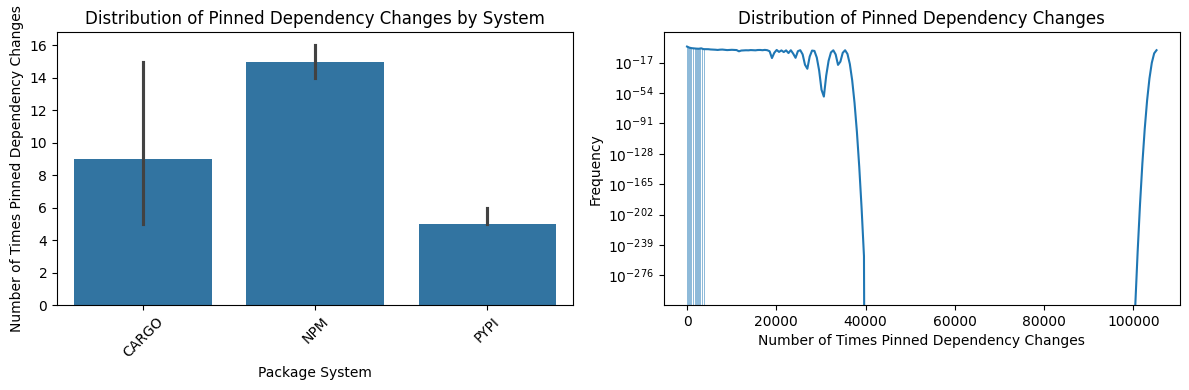

In [11]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Aggregate data by system_name and from_package_name
agg_df = df_pinned_updates.groupby(['system_name', 'from_package_name'])['requirement_changes'].sum().reset_index()

# Plot 1: Violin plot of requirement changes by system
sns.barplot(data=agg_df, x='system_name', y='requirement_changes', ax=ax1, estimator='median', ci=95)
ax1.set_title('Distribution of Pinned Dependency Changes by System')
ax1.set_xlabel('Package System')
ax1.set_ylabel('Number of Times Pinned Dependency Changes')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Distribution plot of requirement changes
sns.histplot(data=agg_df, x='requirement_changes', kde=True, ax=ax2)
ax2.set_title('Distribution of Pinned Dependency Changes')
ax2.set_xlabel('Number of Times Pinned Dependency Changes')
ax2.set_ylabel('Frequency')
ax2.set_yscale('log')

# Adjust layout and display
plt.tight_layout()
plt.savefig('../../results/dep_strategy/requirement_changes_distribution.pdf', bbox_inches='tight')
plt.show()